In [1]:
#%% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import ast
from scipy.ndimage import gaussian_filter
import pickle
import scipy.stats
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
#%%
errors = np.zeros((768))
its = np.zeros((768))
mts = np.zeros((768))

In [11]:
#%%
def euclidean_dist(df):
    errors = list()
    for i in range(len(df)):
        errors.append(np.sqrt((df['target_x'][i] - df['transfer_mouse.x'][i][-1])**2 + (df['target_y'][i] - df['transfer_mouse.y'][i][-1])**2))        

    return errors       
def angular_dist(vec1, vec2):
    uv1 = vec1/np.linalg.norm(vec1)
    uv2 = vec2/np.linalg.norm(vec2)
    dot_prod = np.dot(uv1, uv2)
    return np.arccos(dot_prod)

def rotate(x, y, angle):
    radians = (np.pi/180)*angle
    cos_val = np.cos(radians)
    sin_val = np.sin(radians)
    nx = x*cos_val + y*sin_val
    ny = y*cos_val - x*sin_val
    return [nx, ny];


# Preprocessing

## 0. Read Data

In [12]:
def data_read(participant):
    return pd.read_csv('data/'+str(participant)+'.csv')

## 1. Data Cleanup 

In [13]:
def data_cleanup(data):
    #Preliminary cleanup. Includes dropping NAs, separating in three sets and resetting indices to start from 0
    data_baseline = data.dropna(subset = ['baseline_mouse.x'], inplace = False)
    data_baseline.dropna('columns', inplace = True)
    data_baseline.reset_index(drop = True, inplace = True)
    
    data_rotated = data.dropna(subset = ['rotated_mouse.x'], inplace = False)
    data_rotated.dropna('columns', inplace = True)
    data_rotated.reset_index(drop = True, inplace = True)
    
    data_transfer = data.dropna(subset = ['transfer_mouse.x'], inplace = False)
    data_transfer.dropna('columns', inplace = True)
    data_transfer.reset_index(drop = True, inplace = True)
    
    #Convert string lists to regular lists
    for column in data_rotated.columns:
        try:
            data_rotated[column] = data_rotated[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_baseline.columns:
        try:
            data_baseline[column] = data_baseline[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_transfer.columns:
        try:
            data_transfer[column] = data_transfer[column].apply(ast.literal_eval)            
        except:
            continue
            #print()


    return data_baseline, data_rotated, data_transfer

## 2. Reading fixation positions

In [21]:
def get_fix_positions(cleaned_data, participant):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            baseline_fix_pos[trial][:] = np.array(rotate(data_baseline['baseline_mouse.x'][trial][-1], data_baseline['baseline_mouse.y'][trial][-1], 0))        
        except:
            continue
    rotated_fix_pos = np.zeros((640, 2))
    if participant%2 == 0:
        for trial in range(640):
            try:
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], 90))        
            except:
                continue
    else:
        for trial in range(640):
            try:
                rotation = int(trial/64 + 1) * 10
                if rotation > 90:
                    rotation = 90
                #rotation = 0
                #print(rotation)
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], rotation))
            except:
                #print (participant, trial)
                continue
                #print()
    transfer_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            transfer_fix_pos[trial][:] = np.array(rotate(data_transfer['transfer_mouse.x'][trial][-1], data_transfer['transfer_mouse.y'][trial][-1], 0))        
        except:
            print(participant, trial)
            continue
            #print()
    return baseline_fix_pos, rotated_fix_pos, transfer_fix_pos

## 3. Calculating euclidean and angular errors

In [22]:
def calc_error(cleaned_data, fix_position):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos, rotated_fix_pos, transfer_fix_pos = fix_position
    errors = np.zeros(768)
    ang_errors = np.zeros(768)
    for trial in range(64):
        errors[trial] = np.sqrt((baseline_fix_pos[trial][0] - data_baseline['target_x'][trial])**2 + (baseline_fix_pos[trial][1] - data_baseline['target_y'][trial])**2)
        ang_errors[trial] = angular_dist(baseline_fix_pos[trial], [data_baseline['target_x'][trial], data_baseline['target_y'][trial]])
    for trial in range(640):
        errors[trial+64] = np.sqrt((rotated_fix_pos[trial][0] - data_rotated['target_x'][trial])**2 + (rotated_fix_pos[trial][1] - data_rotated['target_y'][trial])**2)
        ang_errors[trial+64] = angular_dist(rotated_fix_pos[trial], [data_rotated['target_x'][trial], data_rotated['target_y'][trial]])
    for trial in range(64):
        errors[trial+704] = np.sqrt((transfer_fix_pos[trial][0] - data_transfer['target_x'][trial])**2 + (transfer_fix_pos[trial][1] - data_transfer['target_y'][trial])**2)
        ang_errors[trial+704] = angular_dist(transfer_fix_pos[trial], [data_transfer['target_x'][trial], data_transfer['target_y'][trial]])
    return errors, ang_errors

## 4. Pipeline to calculate errors for each participant

In [23]:
def get_errors(participant):
    data = data_read(participant)
    cleaned_data = data_cleanup(data)
    fix_position = get_fix_positions(cleaned_data, participant)
    errors, ang_errors = calc_error(cleaned_data, fix_position)
    #ang_errors = np.nan_to_num(ang_errors, nan = np.nanmean(ang_errors))
    d = {'trial': range(768),
        'errors_temp': errors,
        'ang_errors_temp': ang_errors}
    df = pd.DataFrame(d)
    df['errors'] = df['errors_temp'].interpolate()
    df['ang_errors'] = df['ang_errors_temp'].interpolate()
    return df

In [24]:
a, b, c = data_cleanup(data_read(2009))

Text(0.5, 1.0, 'Sudden')

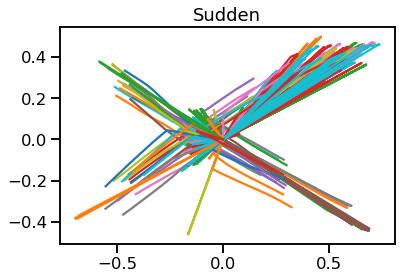

In [25]:
for i in range(64):
    plt.plot(a['baseline_mouse.x'][i], a['baseline_mouse.y'][i])
plt.title('Sudden')

In [26]:
num_participants = 46
ang_errors = np.zeros((num_participants, 768))
errors = np.zeros((num_participants, 768))
participant_ang_errors = np.zeros(num_participants, dtype = object)
for participant in range(2006, 2006+num_participants):
    errors_df = get_errors(participant)
    ang_errors[participant-2006] = gaussian_filter(errors_df['ang_errors'], sigma = 2)
    errors[participant - 2006] = gaussian_filter(errors_df['errors'], sigma = 2)
    participant_ang_errors[participant - 2006] = gaussian_filter(errors_df['ang_errors'], sigma = 2)

2020 0
2029 0
2039 0
2039 1
2039 2
2039 3
2039 4
2039 5
2039 6
2039 7
2039 8
2039 9
2039 10
2039 12
2039 13
2039 14
2039 15
2039 16
2039 17
2039 18
2039 19
2039 20
2039 21
2039 22
2039 23
2039 24
2039 25
2039 26
2039 27
2039 28
2039 29
2039 30
2039 31
2039 33
2039 34
2039 36
2039 37
2039 38
2039 39
2039 40
2039 41
2039 42
2039 43
2039 44
2039 45
2039 46
2039 47
2039 48
2039 49
2039 50
2039 51
2039 52
2039 53
2039 54
2039 55
2039 56
2039 57
2039 58
2039 59
2039 60
2039 61
2039 62
2039 63
2041 1
2041 2
2041 3
2041 4
2041 5
2041 6
2041 7
2041 8
2041 10
2041 11
2041 12
2041 13
2041 14
2041 15
2041 17
2041 19
2041 20
2041 21
2041 24
2041 25
2041 26
2041 27
2041 28
2041 29
2041 30
2041 31
2041 32
2041 33
2041 35
2041 36
2041 37
2041 38
2041 39
2041 41
2041 42
2041 43
2041 44
2041 45
2041 48
2041 51
2041 52
2041 53
2041 55
2041 56
2041 57
2041 58
2041 59
2041 62
2041 63
2043 19
2043 25
2045 2
2045 5
2045 6
2045 8
2045 9
2045 10
2045 11
2045 12
2045 14
2045 15
2045 16
2045 17
2045 18
2045 19
2

In [13]:
ang_errors_df = pd.DataFrame({'Participant_Id': np.repeat(range(2006, 2052), 768), 
                              'Trial_no.': np.tile(range(768), num_participants), 
                              'Block_no': np.tile(np.repeat(range(12), 64), num_participants), 
                              'Angular_Errors': np.ravel(ang_errors)/(np.pi/2),
                              'Rotation': np.hstack((np.tile(np.repeat(['Sudden', 'Gradual'], 768), 23))),
                              'Emphasis': np.hstack((np.repeat(['Accuracy'], 32*768), np.repeat(['Speed'], 14*768)))
                             })


In [14]:
curvatures_smooth = ang_errors.reshape((num_participants, 12, 64))

In [15]:
pickle.dump(curvatures_smooth, open('curvatures_smooth_speed.pickle', 'wb'))

In [16]:
ang_errors_df.to_csv('Angular_Errors.csv')

In [30]:
ang_errors = pickle.load(open('curvatures_smooth.pickle', 'rb'))

In [31]:
ang_errors = ang_errors.reshape(14, 768)

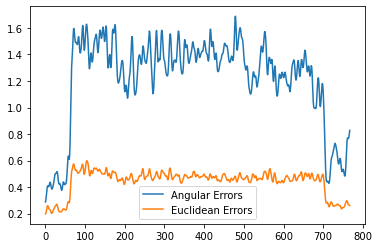

In [20]:
plt_angular, = plt.plot(np.mean(ang_errors[0::2], axis = 0))
plt_euclidean, = plt.plot(np.mean(errors[0::2], axis = 0))
plt.legend((plt_angular, plt_euclidean), ('Angular Errors', "Euclidean Errors"))

In [21]:
p = pd.DataFrame(ang_errors)
p['Condition'] = np.tile(['Sudden', 'Gradual'], 7)
p['participant_id'] = np.arange(14)
p_melt = pd.melt(p, id_vars=['participant_id', 'Condition'], var_name='Trial_number', value_name='Error')
p_melt['Block'] = np.floor(p_melt['Trial_number']/64)

In [2]:
ang_errors_df = pd.read_csv('Angular_errors.csv')

In [28]:
ang_errors_df

,Unnamed: 0,Participant_Id,Trial_no.,Block_no,Angular_Errors,Rotation,Emphasis
0,0,2006,0,0,NaN,Sudden,Accuracy
1,1,2006,1,0,NaN,Sudden,Accuracy
2,2,2006,2,0,NaN,Sudden,Accuracy
3,3,2006,3,0,NaN,Sudden,Accuracy
4,4,2006,4,0,NaN,Sudden,Accuracy
...,...,...,...,...,...,...,...
25339,25339,2038,763,11,0.488163,Sudden,Accuracy
25340,25340,2038,764,11,0.466684,Sudden,Accuracy
25341,25341,2038,765,11,0.407836,Sudden,Accuracy
25342,25342,2038,766,11,0.344527,Sudden,Accuracy


<Figure size 864x432 with 0 Axes>

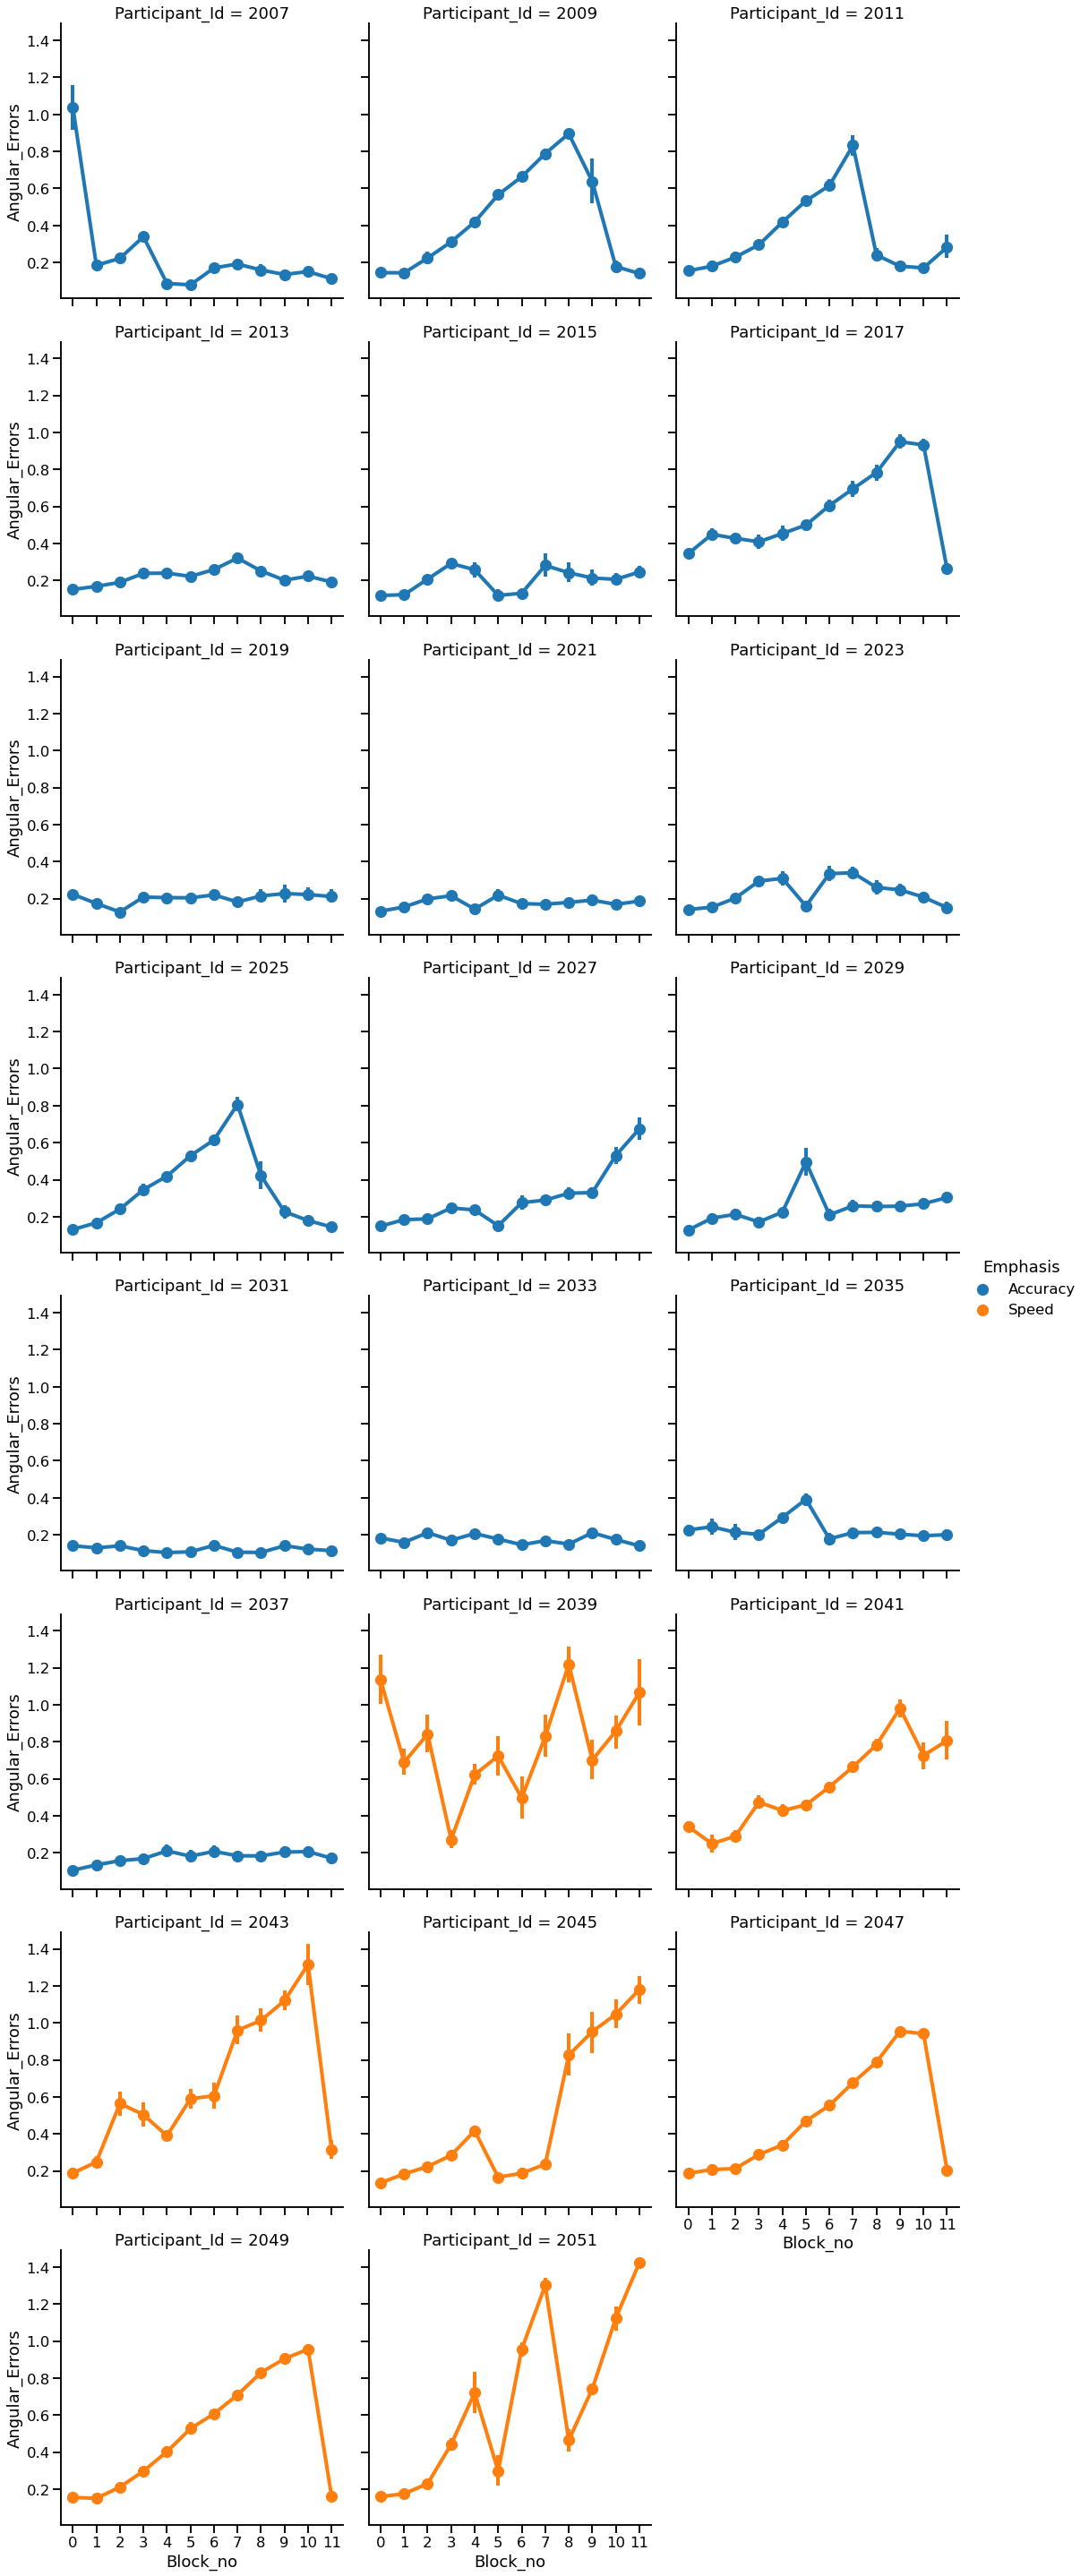

In [27]:
sns.set_context('talk')
plt.figure(figsize=(12, 6))
lp = sns.catplot(x = 'Block_no', y = 'Angular_Errors',  hue = 'Emphasis', col = 'Participant_Id',
                  col_wrap = 3, data = ang_errors_df[ang_errors_df['Rotation'] == 'Gradual'], kind = 'point')


# RTs

In [213]:
a.columns

Index(['target_x', 'target_y', 'rotation', 'baseline_trials.thisRepN',
       'baseline_trials.thisTrialN', 'baseline_trials.thisN',
       'baseline_trials.thisIndex', 'baseline_enclosing_1.started',
       'baseline_enclosing_1.stopped', 'baseline_enclosing.started',
       'baseline_enclosing.stopped', 'baseline_target.started',
       'baseline_target.stopped', 'baseline_fixation.started',
       'baseline_fixation.stopped', 'baseline_mouse.x', 'baseline_mouse.y',
       'baseline_mouse.leftButton', 'baseline_mouse.midButton',
       'baseline_mouse.rightButton', 'baseline_mouse.time',
       'baseline_mouse.started', 'baseline_mouse.stopped',
       'baseline_enclosing_feedback_1.started',
       'baseline_enclosing_feedback_1.stopped',
       'baseline_enclosing_feedback.started',
       'baseline_enclosing_feedback.stopped',
       'baseline_target_feedback.started', 'baseline_target_feedback.stopped',
       'baseline_fixation_feedback.started',
       'baseline_fixation_feedba

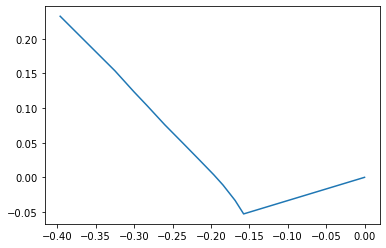

In [223]:
plt.plot(np.array(a['baseline_mouse.x'][trial]), np.array(a['baseline_mouse.y'][trial]))

In [292]:
its = np.zeros((14, 768))
for participant in range(14):
    a, b, c = data_cleanup(data_read(participant+2006))
    for trial in range(64):
        try:
            its[participant][trial] = np.array(a['baseline_mouse.time'][trial])[np.array(a['baseline_mouse.leftButton'][trial]) == 1][0]
        except:
            print(participant, trial)        
    for trial in range(640):
        try:
            its[participant][trial+64] = np.array(b['rotated_mouse.time'][trial])[np.array(b['rotated_mouse.leftButton'][trial]) == 1][0]
        except:
            print(participant, trial+64)
    for trial in range(64):
        try:
            its[participant][trial+704] = np.array(c['transfer_mouse.time'][trial])[np.array(c['transfer_mouse.leftButton'][trial]) == 1][0]
        except:
            print(participant,trial+704)        


0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 28
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 344
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 10
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 400
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 512
2 640
4 165
5 512
5 538
8 192
8 512
9 190
9 256
9 320
9 384
9 512
11 540
11 598


(array([0.58600262, 0.78133683, 1.17200524, 1.95334207, 0.78133683,
        0.39066841, 1.36733945, 0.78133683, 0.97667104, 0.58600262,
        0.39066841, 0.19533421, 0.19533421, 0.39066841, 0.19533421,
        0.19533421, 0.19533421, 0.        , 0.39066841, 0.19533421,
        0.        , 0.39066841, 0.        , 0.        , 0.        ,
        0.19533421, 0.        , 0.        , 0.        , 0.19533421]),
 array([0.45024025, 0.53023136, 0.61022247, 0.69021358, 0.77020469,
        0.8501958 , 0.93018691, 1.01017802, 1.09016913, 1.17016024,
        1.25015135, 1.33014246, 1.41013357, 1.49012468, 1.57011579,
        1.6501069 , 1.73009801, 1.81008912, 1.89008023, 1.97007134,
        2.05006245, 2.13005356, 2.21004467, 2.29003578, 2.37002689,
        2.450018  , 2.5300091 , 2.61000021, 2.68999132, 2.76998243,
        2.84997354]),
 <BarContainer object of 30 artists>)

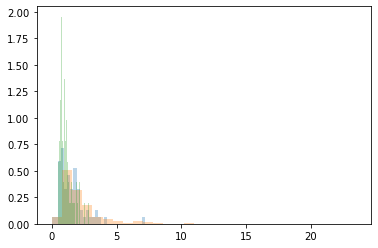

In [312]:
plt.hist(its[13][:64], bins = 30, alpha = 0.3, density=True)
plt.hist(its[13][64:704], bins = 30, alpha = 0.3, density=True)
plt.hist(its[13][704:], bins = 30, alpha = 0.3, density=True)

In [85]:
total_time = gaussian_filter(c['transfer_fixation_feedback.started'] - c['transfer_fixation.started'], sigma = 2)

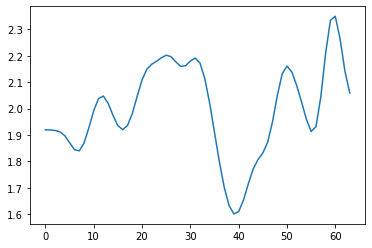

In [86]:
plt.plot(total_time)

In [45]:
df_rt = pd.read_csv('RTs.csv')
df_rt

,Unnamed: 0,participant_id,condition,Trial,ITs,block,MTs
0,0,0,Sudden,0,0.000074,0,0.180820
1,1,1,Gradual,0,0.000075,0,0.274499
2,2,2,Sudden,0,0.000134,0,0.124207
3,3,3,Gradual,0,0.883418,0,0.133209
4,4,4,Sudden,0,0.920651,0,1.510810
...,...,...,...,...,...,...,...
10747,10747,9,Gradual,767,0.780795,11,0.190099
10748,10748,10,Sudden,767,0.733294,11,0.150234
10749,10749,11,Gradual,767,1.200126,11,0.216987
10750,10750,12,Sudden,767,0.560747,11,0.350405


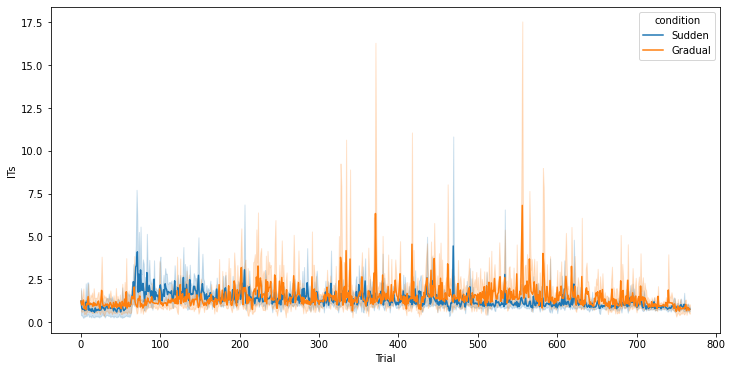

In [47]:
plt.figure(figsize=(12, 6))
lp = sns.lineplot(x = 'Trial', y = 'ITs', hue = 'condition', data = df_rt)


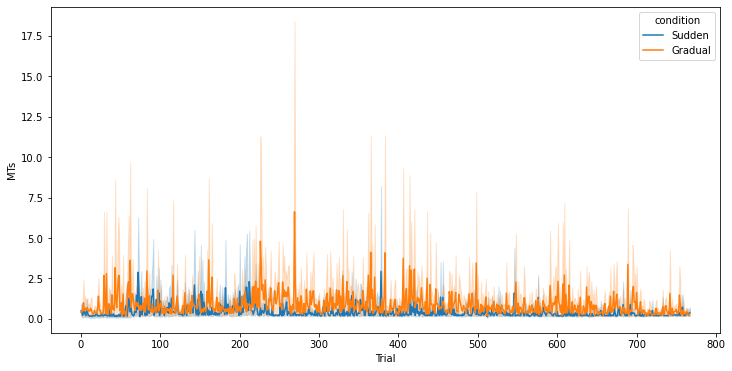

In [48]:
plt.figure(figsize=(12, 6))
lp = sns.lineplot(x = 'Trial', y = 'MTs', hue = 'condition', data = df_rt)
